In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.utils import make_grid

In [2]:
# Check if torch is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: {}".format(torch.cuda.get_device_name(0)))
else:
    device = torch.device("cpu")


Running on GPU: GeForce MX150


In [3]:
# Get MNIST data
IMAGE_SIZE = 64
mnist_data = datasets.MNIST(
    root='data/mnist/', 
    download=True,
   transform=transforms.Compose([
       transforms.Resize(IMAGE_SIZE),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])
)
img_channels = 1


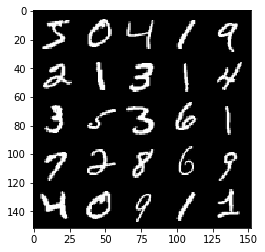

In [4]:
# Look at it!
def show_tensor_imgs(tensor, **kwargs):
    grid = np.transpose(make_grid(tensor, **kwargs).cpu(), (1,2,0))
    plt.imshow(grid)
    
show_tensor_imgs(mnist_data.data[0:25].unsqueeze(1), nrow=5)

In [5]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels, init_channels, kernel_size=4, stride=2, padding=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, init_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels, init_channels*2, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*2, init_channels*4, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*4, init_channels*8, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*8),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [6]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, img_channels, target_channels, init_size, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(init_size, target_channels * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(target_channels * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 8, target_channels * 4, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 4, target_channels * 2, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 2, target_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [8]:
init_conv_layers = 64
noise_size = 100

In [9]:
# Create networks and apply weight initializers
disc = Discriminator(img_channels, init_conv_layers).to(device)
disc.apply(weights_init)
print(disc)

gen = Generator(img_channels, init_conv_layers, noise_size).to(device)
gen.apply(weights_init)
print(gen)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=Fa

In [10]:
loss = nn.BCELoss()

batch_size = 32
lr = 0.0002
example_noise = torch.randn(batch_size, noise_size, 1, 1)
real_label = 1
fake_label = 0

# setup optimizer
optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

Iteration: 0, D Loss: 1.6202, G Loss: 5.7350


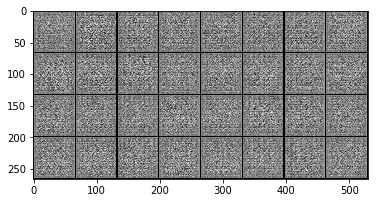

Iteration: 100, D Loss: 0.0966, G Loss: 4.8185
Iteration: 200, D Loss: 0.4940, G Loss: 3.9615
Iteration: 300, D Loss: 1.1669, G Loss: 4.1615
Iteration: 400, D Loss: 0.3626, G Loss: 3.1177
Iteration: 500, D Loss: 0.5704, G Loss: 3.1210


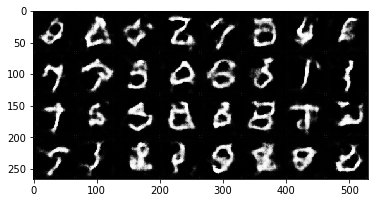

Iteration: 600, D Loss: 1.3741, G Loss: 1.6150
Iteration: 700, D Loss: 0.4954, G Loss: 2.4664
Iteration: 800, D Loss: 0.7783, G Loss: 7.1379
Iteration: 900, D Loss: 0.3928, G Loss: 2.7308
Iteration: 1000, D Loss: 0.4880, G Loss: 5.1944


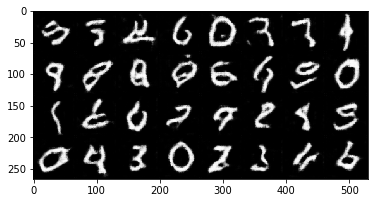

Iteration: 1100, D Loss: 0.5715, G Loss: 1.9003
Iteration: 1200, D Loss: 0.7073, G Loss: 2.7034
Iteration: 1300, D Loss: 1.2108, G Loss: 7.5381
Iteration: 1400, D Loss: 0.2735, G Loss: 2.9718
Iteration: 1500, D Loss: 0.2637, G Loss: 4.2412


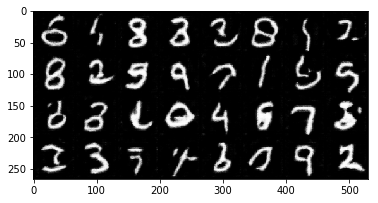

Iteration: 1600, D Loss: 0.4333, G Loss: 3.7276
Iteration: 1700, D Loss: 0.4663, G Loss: 2.7080
Iteration: 1800, D Loss: 0.3591, G Loss: 2.5552


In [11]:
loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
d_losses = []
g_losses = []
for i, data in enumerate(loader):
    ####### Discriminator error ######
    disc.zero_grad()
    
    # Get batch data
    batch = data[0].to(device)
    batch_size = batch.size(0)
    batch_labels = torch.full((batch_size,), real_label, device=device)
    
    # Real data error
    real_output = disc(batch)
    real_err = loss(real_output, batch_labels)
    real_err.backward()
    
    # Generate fake data
    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    fake = gen(noise)
    batch_labels.fill_(fake_label)
    
    # Fake data error
    fake_output = disc(fake.detach())
    fake_err_d = loss(fake_output, batch_labels)
    fake_err_d.backward()
    
    err_d = real_err + fake_err_d
    err_d_item = err_d.item()
    d_losses.append(err_d_item)
    optimizer_disc.step() 
    # Fake data error
    
    ###### Generator error ######
    gen.zero_grad()
    
    # Generator labels are opposite of discriminator labels
    batch_labels.fill_(real_label)
    fake_output = disc(fake)
    err_g = loss(fake_output, batch_labels)
    err_g.backward()
    err_g_item = err_g.item()
    g_losses.append(err_g_item)
    optimizer_gen.step()
    
    if i % 100 == 0:
        print(f"Iteration: {i}, D Loss: {err_d.item():.4f}, G Loss: {err_g.item():.4f}")
    
    if i % 500 == 0:
        show_tensor_imgs(gen(noise).detach(), normalize=True)
        plt.show()
   

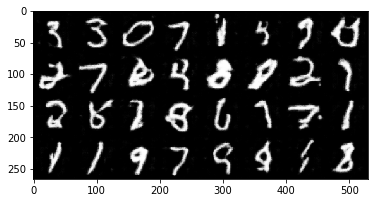

In [12]:
show_tensor_imgs(gen(noise).detach(), normalize=True)

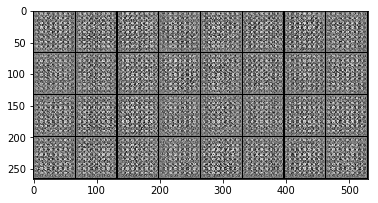

In [17]:
# Re-initialize both networks

disc.apply(weights_init)
gen.apply(weights_init)
show_tensor_imgs(gen(noise).detach(), normalize=True)

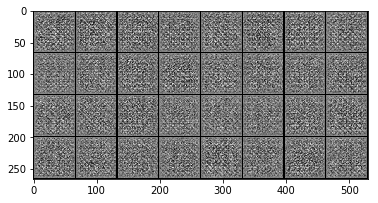